In [1]:
# load h5s -> dataloader #
##########################

base_dir = "/mnt/bigdata/placenta/"
h5_subdir = "h5-infer-ep"

import lib
import torch
from pathlib import Path

base_dir = Path(base_dir)
h5folder = base_dir / Path(h5_subdir)
h5files = list(h5folder.glob("*.h5path"))
datasets = []
ds_fullsize = 0

for h5file in h5files:
    print(f"creating dataset from {str(h5file)} with TransformedPathmlTileSet")
    datasets.append(lib.TransformedPathmlTileSet(h5file))

full_ds = torch.utils.data.ConcatDataset(datasets)

dataloader = torch.utils.data.DataLoader(
    full_ds, batch_size=128, shuffle=True, num_workers=0, pin_memory=True
)

2024-01-08 18:42:31.829348: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-08 18:42:31.964701: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-08 18:42:31.964739: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-08 18:42:31.986518: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-08 18:42:32.033853: I tensorflow/core/platform/cpu_feature_guar

creating dataset from /mnt/bigdata/placenta/h5-infer-ep/20230815_095205_a.h5path with TransformedPathmlTileSet


In [2]:
# load model #
##############

model_checkpoint_file = "/mnt/bigdata/placenta/training_checkpoints/orchid-ibex27.ckpt"

model = torch.hub.load(
    'moskomule/senet.pytorch',
    'se_resnet50',
    pretrained=True,
    verbose=True
)


checkpoint = torch.load(model_checkpoint_file)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)
model.load_state_dict(checkpoint["model_state_dict"])

Using cache found in /home/peet/.cache/torch/hub/moskomule_senet.pytorch_master


<All keys matched successfully>

In [3]:
# init tensorboard writer #
###########################
# from torch.utils.tensorboard import SummaryWriter
# # tensorboard --logdir /mnt/bigdata/placenta/tensorboard_data
# # firefox http://localhost:6006/
# session_name = model_checkpoint.split(".")[0][:-1]
# tensorboard_log_dir = base_dir / "tensorboard_data" / session_name

# writer = SummaryWriter(log_dir=tensorboard_log_dir, comment="inference")

# ...
# writer.add_figure("ROC/AUC fig", fig, global_step=None, close=True, walltime=None)   
# writer.add_graph(model, images)

In [4]:
# load wsi #
############

tile_size = 500
wsi_file = "/mnt/bigdata/placenta/wsi/20230815_095205_a.tiff"

import matplotlib.pyplot as plt
# from pathml.utils import plot_mask
from pathml.core import HESlide, Tile, types


pml_wsi = HESlide(
        wsi_file,
        backend="openslide",
        slide_type=types.HE,
    )

print("some details of ", pml_wsi.name)
print("shape: ", pml_wsi.shape)
print("level_count: ", pml_wsi.slide.level_count)
print("level_downsamples (from 0 index to n): ", pml_wsi.slide.slide.level_downsamples)
print("level_dimensions (h,w): ", pml_wsi.slide.slide.level_dimensions)
try:
    print("color profile: ", pml_wsi.slide.slide.color_profile.profile.profile_description)
except:
    print("no color profile information found")
print("rgb?: ", pml_wsi.slide_type.rgb)
print("masks: ", len(pml_wsi.masks))
print("tiles: ", len(pml_wsi.tiles))
print("labels: ", pml_wsi.labels)

some details of  20230815_095205_a.tiff
shape:  (97792, 188416)
level_count:  10
level_downsamples (from 0 index to n):  (1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0)
level_dimensions (h,w):  ((188416, 97792), (94208, 48896), (47104, 24448), (23552, 12224), (11776, 6112), (5888, 3056), (2944, 1528), (1472, 764), (736, 382), (368, 191))
no color profile information found
rgb?:  True
masks:  0
tiles:  0
labels:  None


In [5]:
# function to get tile keys and predictions for each slide #
############################################################
import numpy as np

def infer(dataloader, model, slide_dim: tuple, tile_size = 500) -> dict():
    """ running model evaluation to get tile predictions and keys to later
        rebuild the slide and assign tile prediction values for each slide
        resulting in a heatmap

    Args:
        dataloader (torch.utils.data.dataloader.DataLoader, model): pytorch dataloader and trained model

    Returns:
        dict: keys = wsi filename, values = array of size the number of tiles in wsi, values are prediction values per tile  
    """
    device                          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using {device}")
    if torch.backends.cudnn.enabled == False:
        print("WARNING: torch.backends.cudnn not enabled!")
    torch.backends.cudnn.benchmark  = True

    model = model.to(device)
    model.eval()
    
    # heatmask array has 1 pixel per tile
    slide_dim_mini = (slide_dim[0]//tile_size, slide_dim[1]//tile_size)
    heatmask                = np.zeros(slide_dim_mini, dtype=np.float32)
    batch_predictions       = []
    predictions             = []

    with torch.no_grad():
        for images, _, labels_dict, _ in dataloader:
            batch_size = len(images)
            images = images.to(device)
            outputs = model(images)
            probabilities = torch.sigmoid(outputs)
            batch_predictions = probabilities[:, 1].cpu().numpy()
            predictions.extend(batch_predictions)

            for i in range(batch_size):
                tile_keys = labels_dict['tile_key'][i].split(",") # already at i index
                tile_x = tile_keys[0][1:]
                tile_y = tile_keys[1][:-1]
                heatmask[int(tile_x)//tile_size, int(tile_y)//tile_size] = batch_predictions[i]  
    
    return predictions, heatmask

preds, heatmask = infer(dataloader, model, slide_dim=pml_wsi.shape, tile_size = 500)

# import sys
# np.set_printoptions(threshold=sys.maxsize)
# print(heatmask)

threshold = 0.9
positiles = int(sum(p for p in preds if p > threshold))
print(f"with a treshold of {threshold}, {positiles} tiles of total {len(preds)} ({int(positiles / len(preds) * 100)}%) found to have an endpoint")

Using cuda
with a treshold of 0.9, 6234 tiles of total 29005 (21%) found to have an endpoint


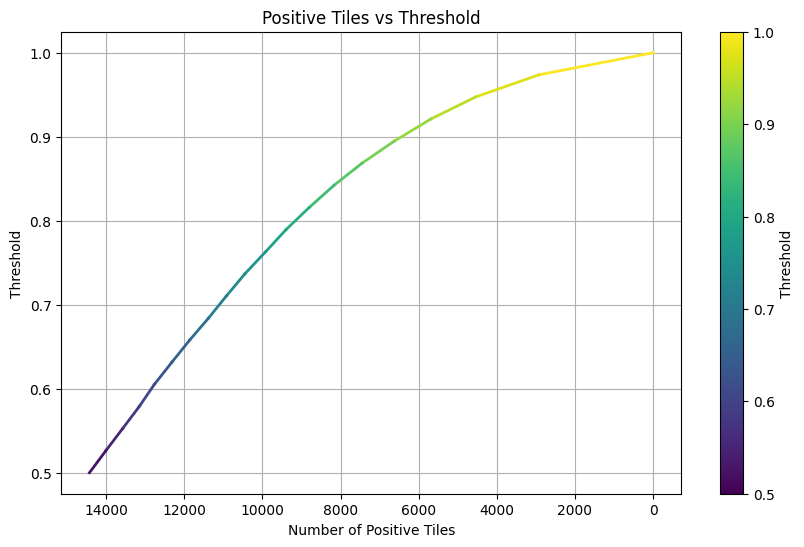

In [6]:
# display 'roc' curve #
#######################

import matplotlib.pyplot as plt
import numpy as np

# create a range of thresholds
thresholds = np.linspace(1, 0.5, num=20)  # 50 thresholds from 0 to 1

# calculate positive tiles for each threshold
positiles_per_threshold = [sum(p > threshold for p in preds) for threshold in thresholds]

# normalize threshold values for color mapping
norm = plt.Normalize(vmin=min(thresholds), vmax=max(thresholds))
cmap = plt.cm.viridis

fig, ax = plt.subplots(figsize=(10, 6))

# plot each segment with color mapping to the thresholds
for i in range(len(thresholds) - 1):
    color = cmap(norm(thresholds[i]))
    ax.plot(positiles_per_threshold[i:i+2], thresholds[i:i+2], color=color, lw=2)

# colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Important to ensure the colorbar works with our custom colors
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Threshold')

ax.set_xlabel('Number of Positive Tiles')
ax.set_ylabel('Threshold')
ax.set_title('Positive Tiles vs Threshold')

# mirror chart horizontally by reversing the x-axis
ax.set_xlim(ax.get_xlim()[::-1])

plt.grid(True)
plt.show()

Working with pyramid resolution level 4 shape: (6112,)


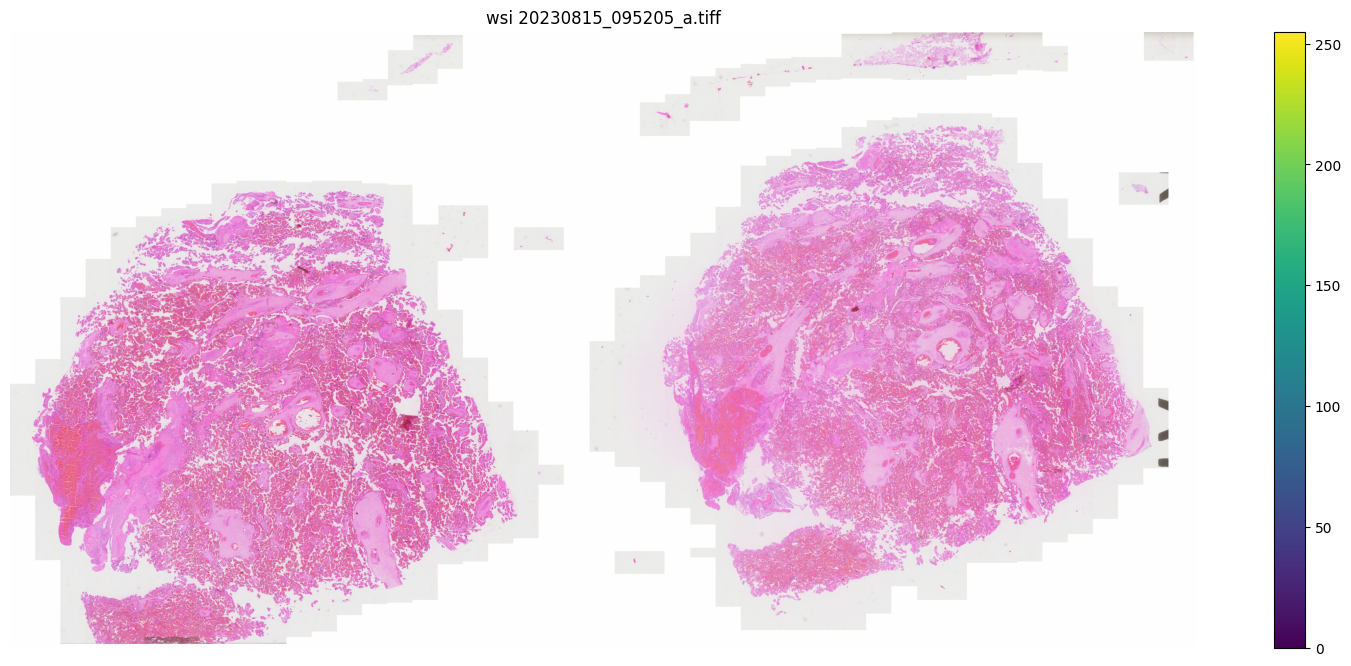

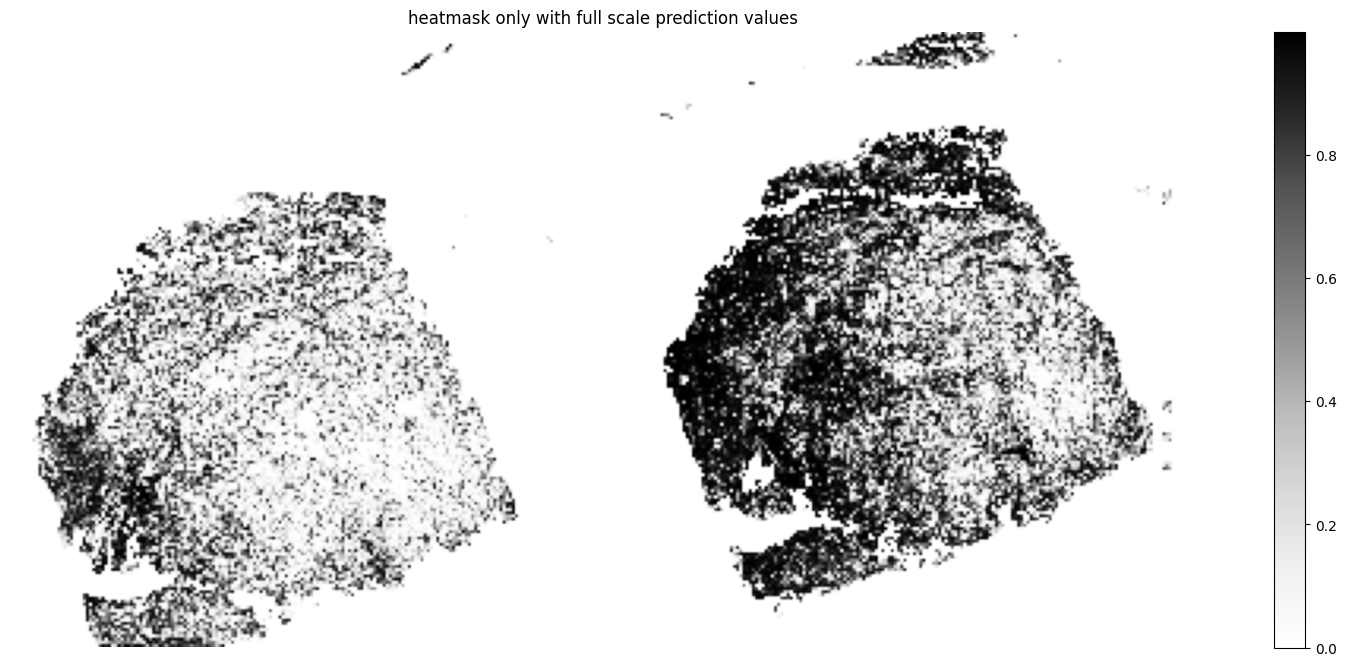

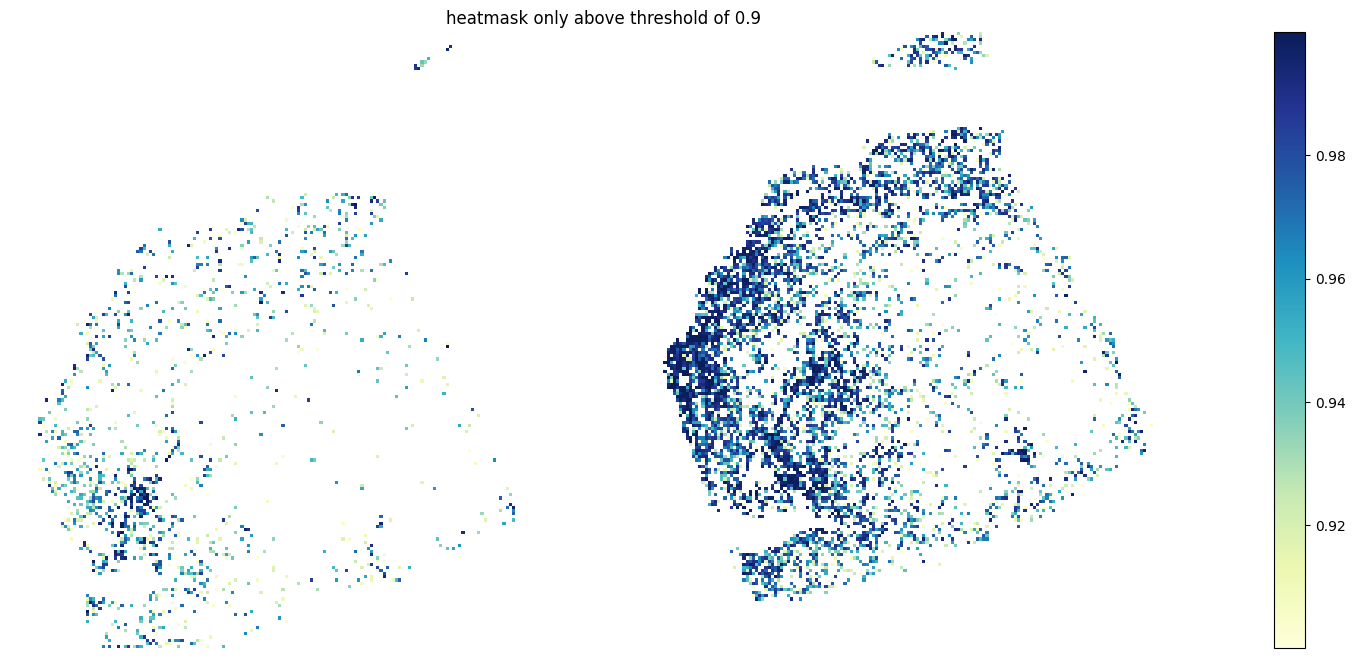

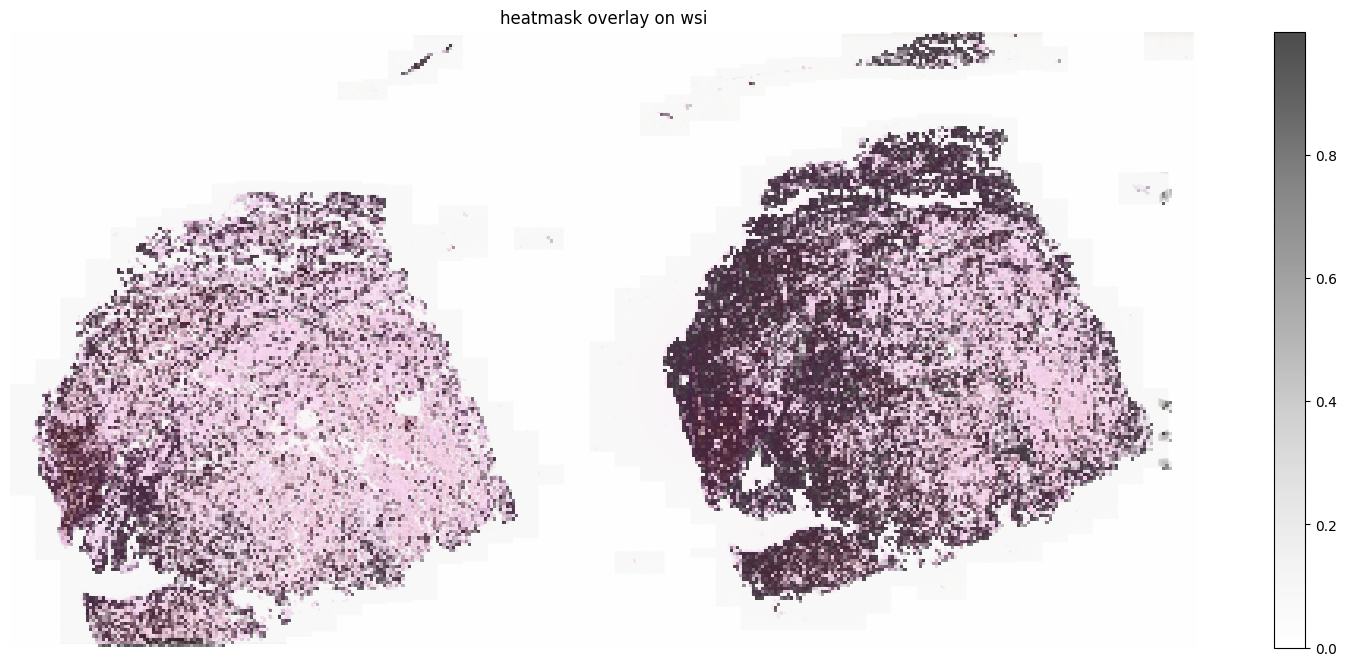

In [7]:
# display heatmask on wsi #
###########################
import numpy.ma as ma

try:
    resolution_level = 4   # 0 is the highest resolution, need to use the index of level_downsamples
    # dimensions are transposed!!! needed to invert.. (pml_wsi.slide.slide.level_dimensions[0][1], pml_wsi.slide.slide.level_dimensions[0][0]))
    region = pml_wsi.slide.extract_region(
        location=(0, 0),
        size=(pml_wsi.slide.slide.level_dimensions[resolution_level][1], pml_wsi.slide.slide.level_dimensions[resolution_level][0]),
        level=resolution_level
        )
    print("Working with pyramid resolution level", resolution_level, "shape:", region.shape[0:1])
except Exception as e:
    print("Resolution level not found, using original size. Error: ", e)
    # dimensions are transposed!!! needed to invert.. (pml_wsi.slide.slide.level_dimensions[0][1], pml_wsi.slide.slide.level_dimensions[0][0]))
    region = pml_wsi.slide.extract_region(
        location=(0, 0),
        size=(pml_wsi.slide.slide.level_dimensions[0][1], pml_wsi.slide.slide.level_dimensions[0][0])
        )

def customTile():
    return Tile(region, coords=(0, 0), name="testregion", slide_type=types.HE)

tile = customTile()

# display original image only
plt.figure(figsize=(20, 8))
wsi_height, wsi_width = pml_wsi.shape
extent = [0, wsi_width, wsi_height, 0]
plt.imshow(region, extent=extent)
plt.colorbar()
plt.title(f'wsi {pml_wsi.name}')
plt.axis('off')
plt.show()

# display heatmask with all values
plt.figure(figsize=(20, 8))
wsi_height, wsi_width = pml_wsi.shape
extent = [0, wsi_width, wsi_height, 0]
plt.imshow(heatmask, cmap='Greys', alpha=1, extent=extent, interpolation='hamming')
plt.colorbar()
plt.title('heatmask only with full scale prediction values')
plt.axis('off')
plt.show()

# display heatmask with threshold
plt.figure(figsize=(20, 8))
wsi_height, wsi_width = pml_wsi.shape
extent = [0, wsi_width, wsi_height, 0]
thresholded_heatmask = ma.masked_outside(heatmask, threshold, 1)
plt.imshow(thresholded_heatmask, cmap='YlGnBu', alpha=1, extent=extent, interpolation='nearest')
plt.colorbar()
plt.title(f'heatmask only above threshold of {threshold}')
plt.axis('off')
plt.show()

# display heatmask drawn on wsi
plt.figure(figsize=(20, 8))
wsi_height, wsi_width = pml_wsi.shape
# extent = [0, wsi_width, wsi_height, 0] ??? also works 
extent = [0, wsi_width, wsi_height, 0]
plt.imshow(region, extent=extent)
plt.imshow(heatmask, cmap='Greys', alpha=0.7, extent=extent, interpolation='nearest')
plt.colorbar()
plt.title('heatmask overlay on wsi')
plt.axis('off')
plt.show()


In [8]:
# and play some music as well
import subprocess
mp3_file_path = '/home/peet/Downloads/clean-trap-loop-131bpm-136738.mp3'
subprocess.run(['mpg123', mp3_file_path])

High Performance MPEG 1.0/2.0/2.5 Audio Player for Layer 1, 2, and 3.
Version 0.3.2-1 (2012/03/25). Written and copyrights by Joe Drew,
now maintained by Nanakos Chrysostomos and others.
Uses code from various people. See 'README' for more!
THIS SOFTWARE COMES WITH ABSOLUTELY NO WARRANTY! USE AT YOUR OWN RISK!
tcgetattr(): Inappropriate ioctl for device

Directory: /home/peet/Downloads
Playing MPEG stream from clean-trap-loop-131bpm-136738.mp3 ...
MPEG 1.0 layer III, 256 kbit/s, 44100 Hz joint-stereo
                                                                            
[0:07] Decoding of clean-trap-loop-131bpm-136738.mp3 finished.


CompletedProcess(args=['mpg123', '/home/peet/Downloads/clean-trap-loop-131bpm-136738.mp3'], returncode=0)